In [19]:
%load_ext autoreload
%autoreload 2
# import torch; torch.manual_seed(955)
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from dataGen import Gen, FastGen, Gen2
from Encoders import LongShort_TCVAE_Encoder, RnnEncoder, MST_VAE_Encoder, MST_VAE_Encoder_dist
from Decoders import LongShort_TCVAE_Decoder, RnnDecoder, MST_VAE_Decoder, MST_VAE_Decoder_dist
from vae import Variational_Autoencoder, VQ_MST_VAE, VQ_Quantizer
from utils import * #train_on_effect, generate_data, extract_parameters, suppress_prints, add_mu_std
from train import *
import argparse
import numpy as np
import matplotlib.pyplot as plt
import pprint
torch.set_printoptions(sci_mode=False)

# all parameters for generating the time series should be configured in this cell
        
p=2       
args = GENV(n_channels=2, n_samples=100, shuffle=False, periode=p, L=288*p, min_max=False)
effects = {
    "Pulse": {
        "occurances":1,
        "max_amplitude":5,   
        "interval":40,
        "start":None
        },
    "Trend": {
        "occurances":10,
        "max_slope":0.002,
        "type":"linear",
        "start":None
        },
    "Seasonality": {
        "occurances":10,
        "frequency_per_week":(7, 14), # min and max occurances per week
        "amplitude_range":(5, 20),
        "start":-5
        },
    "std_variation": {
        "occurances":0,
        "max_value":10,
        "interval":30,
        "start":None
        },
    "channels_coupling":{
        "occurances":0,
        "coupling_strengh":20
        },
    "Noise": {
        "occurances":0,
        "max_slope":0.005,
        "type":"linear"
        }
    }

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
from importlib import reload
from Encoders import LongShort_TCVAE_Encoder#, RnnEncoder, MST_VAE_Encoder, MST_VAE_Encoder_dist
from Decoders import LongShort_TCVAE_Decoder#, RnnDecoder, MST_VAE_Decoder, MST_VAE_Decoder_dist
from vae import Variational_Autoencoder, VQ_MST_VAE, VQ_Quantizer
# args.latent_dims = 30
args.num_embed =512

v = Variational_Autoencoder(args,
                            v_encoder = LongShort_TCVAE_Encoder, #MST_VAE_Encoder,
                            v_decoder = LongShort_TCVAE_Decoder #MST_VAE_Decoder,
                           )
# v = VQ_MST_VAE(args,
#                 v_encoder = LongShort_TCVAE_Encoder, #MST_VAE_Encoder,
#                 v_decoder = LongShort_TCVAE_Decoder, #MST_VAE_Decoder,
#                 v_quantizer = VQ_Quantizer) #10 5

v = v.to(args.device)

encoder = v.encoder
opt_enc = optim.Adam(encoder.parameters(), lr=0.0001)

decoder = v.decoder
opt_dec = optim.Adam(decoder.parameters(), lr=0.0001)

opt = optim.Adam(v.parameters(), lr = 0.0002043529186448577) # 0.005043529186448577 0.006819850049647945
# print(v)

generating:  1
generating:  2
generating:  3
generating:  4
generating:  5
generating:  6
generating:  7
generating:  8
generating:  9
(9000,)


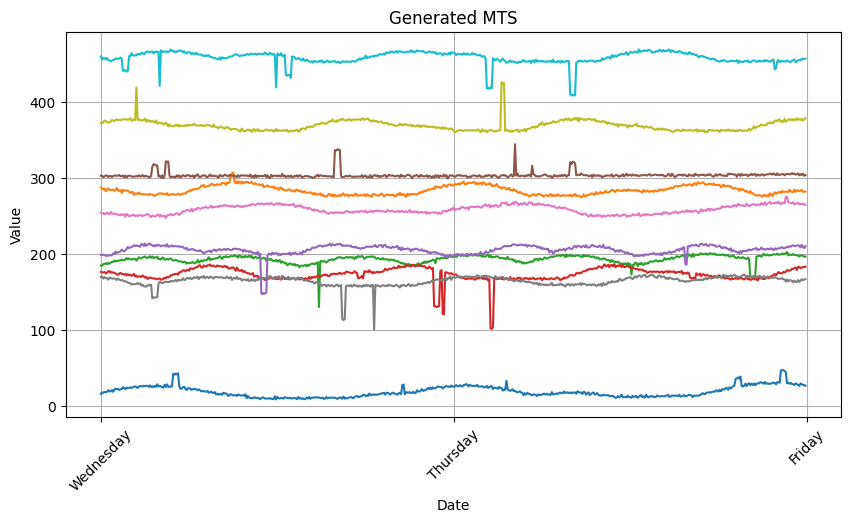

In [21]:
train_data, val_data, test_data, X = generate_labeled_data(args, effects, effect="both", occurance=5, return_gen=True)

(1747,)
(1, 2, 104832)


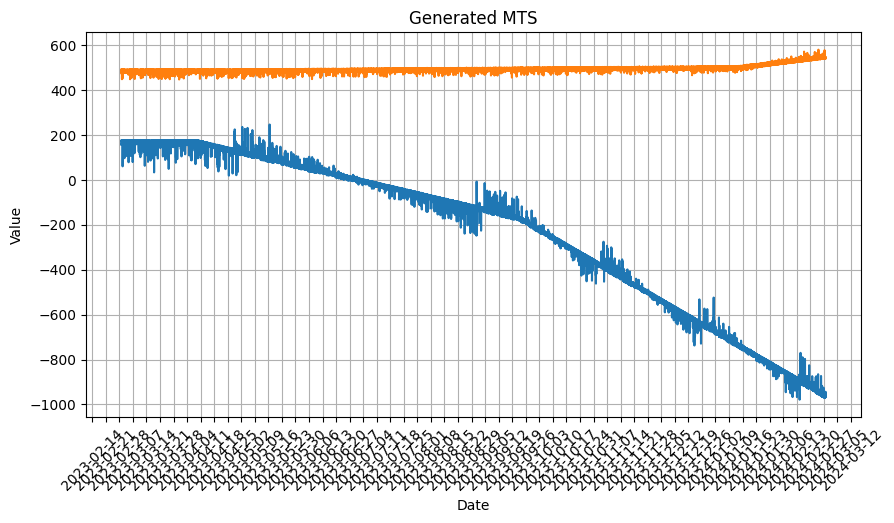

In [22]:
# args.min_max=False
# args.n_channels = 10
train_data_long, val_data_long, test_data_long, X_long = generate_long_data(args, effects, effect="both", occurance=5, return_gen=True)

In [23]:
Origin_norm_long, REC_norm_long, _ = rebuild_TS_non_overlapping(v, train_data_long, args, keep_norm=True)
denoised_rec_long = denoise_data(REC_norm_long.T.cpu())
denoised_orig_long = denoise_data(Origin_norm_long.T.cpu())
train_data_long_denoised = DataLoader(StridedWindow(torch.from_numpy(denoised_orig_long), args),  # slidingWindow, stridedWindow
                            batch_size=args.bs,  # 59, # 22
                            shuffle=False,
                            drop_last=False
                            )

In [24]:
x, params, e_params = X.parameters()
Origin_norm, REC_norm, _ = rebuild_TS(v, train_data, args, keep_norm=True)

labels = extract_parameters(args, e_params=e_params, effects=effects)
labels = add_mu_std(labels, params)
train_labels = labels[:Origin_norm.shape[0]]
                      
denoised_rec = denoise_data(REC_norm.cpu())
denoised_orig = denoise_data(Origin_norm.cpu())
train_data_denoised = DataLoader(NoWindow(torch.from_numpy(denoised_orig), args, train_labels, norm=True),  # slidingWindow, stridedWindow
                            batch_size=args.bs,  # 59, # 22
                            shuffle=False,
                            drop_last=False
                            )

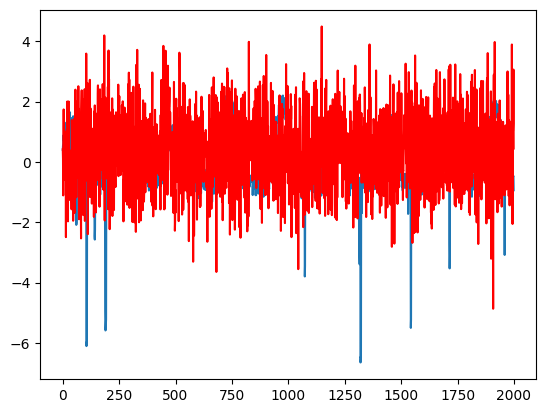

In [26]:
plt.plot(Origin_norm_long[:2000,1].cpu())
plt.plot(REC_norm_long[:2000,1].cpu(), "r-")

In [34]:
x, params, e_params = X.parameters()
frs = e_params["Seasonality"]["frequency_per_week"]
arr = np.array(frs)
arr[15]

array([12.94469474, 12.36471355,  7.28954081,  7.14528718,  9.44694033])

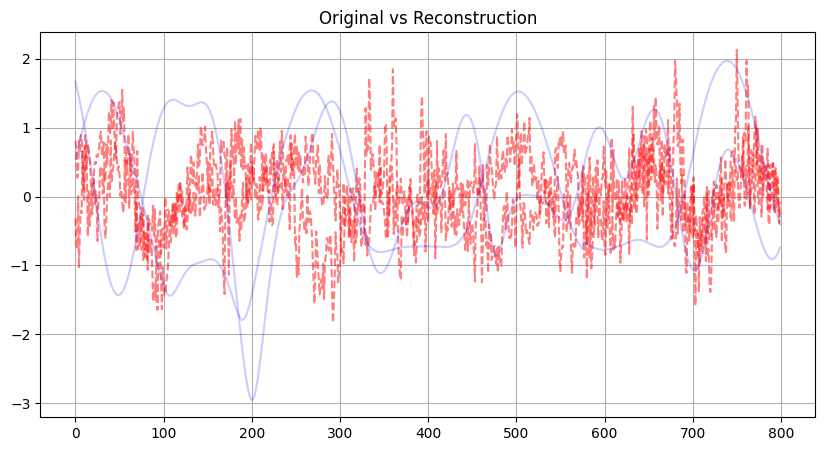

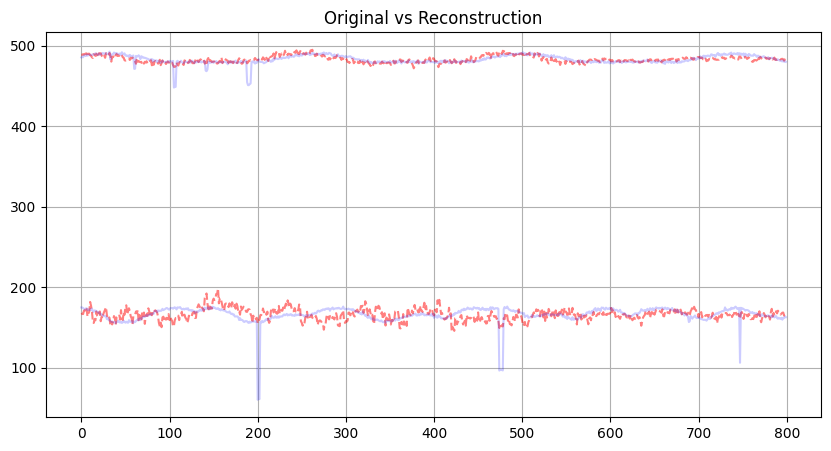

====> Sample: 501 Average loss: 0.0217
Train Epoch: 502 [0/1 (0%)]	Loss: 3.140069	 True Loss: 455.309937
====> Epoch: 502 Average loss: 3.1401
====> Sample: 502 Average loss: 0.0217


KeyboardInterrupt: 

In [28]:
np.set_printoptions(suppress=True)
VQ_losses = []

for epoch in range(1, 1000):
    loss = train(v, train_data_long, args, opt, epoch)
    
    if epoch%100 == 1:
        display.clear_output(wait=True)
        Origin_no_norm, REC_no_norm, _ = rebuild_TS_non_overlapping(v, train_data_long_denoised, args, keep_norm=True)

        Origin, REC, indices = rebuild_TS_non_overlapping(v, train_data_long, args)
#         print(Origin.shape, REC.shape, indices.shape)
        plot_rec(Origin_no_norm[:800].cpu(), REC_no_norm[:800].cpu())

        plot_rec(Origin[:800].cpu(), REC[:800].cpu())
#         codebook = v.quantizer._embedding.weight
#         heatmap = create_heatmap(codebook.cpu().detach().numpy() )
#         plot_indices(indices.cpu())
        
    VQ_losses.append(loss)
        
    print('====> Sample: {} Average loss: {:.4f}'.format(epoch, loss / len(train_data_long.dataset)))

In [17]:
days = 7
# N = 288 * days
N=len(denoised[1,0])
n=2
results = []
i = 0
while len(results) < n:
    i += 1
    Amps = sf.rfft(denoised[15,0]) #/ N
    freqs = sf.rfftfreq(n=N, d=1/(24*12*7))
    
    max_freq_ind = np.argpartition(np.abs(Amps), -i)[-i:]
    results = filter_close_values(freqs[max_freq_ind], 0.02)
#     results = freqs[max_freq_ind]
# print(max_freq_ind)
print(abs(Amps[max_freq_ind]))
# print((freqs))
print(results)
print([result%14 for result in results])

plt.stem(freqs[max_freq_ind])
# frs

NameError: name 'denoised' is not defined

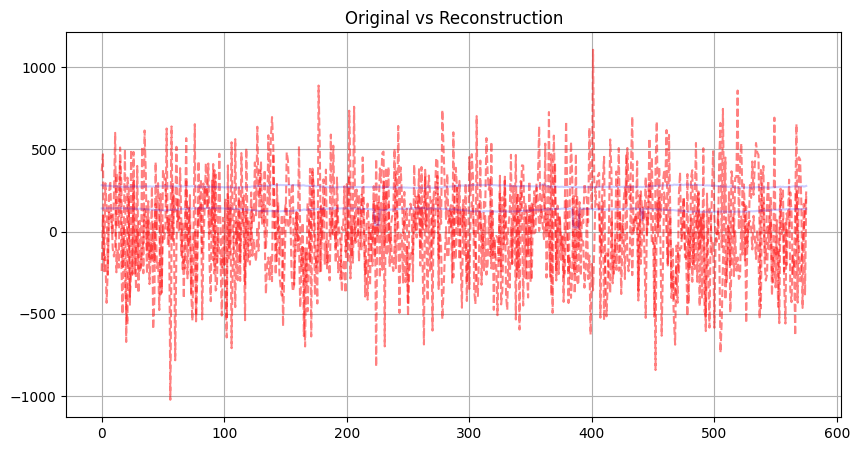

====> Sample: 501 Average loss: 0.0795
Train Epoch: 502 [0/4 (0%)]	Loss: 9.003086	 True Loss: 2304.790039
====> Epoch: 502 Average loss: 11.5232
====> Sample: 502 Average loss: 0.0795
Train Epoch: 503 [0/4 (0%)]	Loss: 9.003076	 True Loss: 2304.787354
====> Epoch: 503 Average loss: 11.5232
====> Sample: 503 Average loss: 0.0795
Train Epoch: 504 [0/4 (0%)]	Loss: 9.003065	 True Loss: 2304.784668
====> Epoch: 504 Average loss: 11.5232
====> Sample: 504 Average loss: 0.0795
Train Epoch: 505 [0/4 (0%)]	Loss: 9.003056	 True Loss: 2304.782227
====> Epoch: 505 Average loss: 11.5232
====> Sample: 505 Average loss: 0.0795
Train Epoch: 506 [0/4 (0%)]	Loss: 9.003045	 True Loss: 2304.779541
====> Epoch: 506 Average loss: 11.5232
====> Sample: 506 Average loss: 0.0795
Train Epoch: 507 [0/4 (0%)]	Loss: 9.003035	 True Loss: 2304.776855
====> Epoch: 507 Average loss: 11.5232
====> Sample: 507 Average loss: 0.0795
Train Epoch: 508 [0/4 (0%)]	Loss: 9.003025	 True Loss: 2304.774414
====> Epoch: 508 Average

====> Epoch: 559 Average loss: 11.5227
====> Sample: 559 Average loss: 0.0795
Train Epoch: 560 [0/4 (0%)]	Loss: 9.002558	 True Loss: 2304.654785
====> Epoch: 560 Average loss: 11.5227
====> Sample: 560 Average loss: 0.0795
Train Epoch: 561 [0/4 (0%)]	Loss: 9.002550	 True Loss: 2304.652832
====> Epoch: 561 Average loss: 11.5226
====> Sample: 561 Average loss: 0.0795
Train Epoch: 562 [0/4 (0%)]	Loss: 9.002542	 True Loss: 2304.650879
====> Epoch: 562 Average loss: 11.5226
====> Sample: 562 Average loss: 0.0795
Train Epoch: 563 [0/4 (0%)]	Loss: 9.002534	 True Loss: 2304.648682
====> Epoch: 563 Average loss: 11.5226
====> Sample: 563 Average loss: 0.0795
Train Epoch: 564 [0/4 (0%)]	Loss: 9.002526	 True Loss: 2304.646729
====> Epoch: 564 Average loss: 11.5226
====> Sample: 564 Average loss: 0.0795
Train Epoch: 565 [0/4 (0%)]	Loss: 9.002519	 True Loss: 2304.644775
====> Epoch: 565 Average loss: 11.5226
====> Sample: 565 Average loss: 0.0795
Train Epoch: 566 [0/4 (0%)]	Loss: 9.002511	 True Los

KeyboardInterrupt: 

In [13]:
import torcheck
np.set_printoptions(suppress=True)
VQ_losses = []
# torcheck.add_module_changing_check(model, module_name="vae")
# torcheck.add_module_output_range_check(
#     v,
#     output_range=(0, 2),
#     negate_range=True,
# )
dataset = train_data_long.dataset.data
for epoch in range(1, 1000):
    loss = train(v, train_data, args, opt, epoch)
    
    if epoch%100 == 1:
        display.clear_output(wait=True)
        Origin_no_norm, REC_no_norm, indices = rebuild_TS(v, train_data, args, keep_norm=True)
        Origin, REC, indices = rebuild_TS(v, train_data, args)
#         print(Origin.shape, REC.shape, indices.shape)
        plot_rec(Origin[0].T.cpu(), REC[0].T.cpu())
#         codebook = v.quantizer._embedding.weight
#         heatmap = create_heatmap(codebook.cpu().detach().numpy() )
#         plot_indices(indices[1].cpu())
        
    VQ_losses.append(loss)
        
    print('====> Sample: {} Average loss: {:.4f}'.format(epoch, loss / len(train_data_long.dataset)))

In [651]:
shape = train_data_long.dataset.data.shape
shape[:-1]
np.expand_dims(np.empty(shape[:-1]), axis=-1).shape

(1, 1)

In [949]:
2/365

0.005479452054794521

In [30]:
def rescale_x_axis(ts, args):
    n = len(ts)
    t = np.arange(n)
    scale_factor = 365 / args.periode
    new_n = int(scale_factor * n)

    # Generate new time vector and zero-padded time series
    new_t = np.linspace(0, n - 1, new_n)
    new_ts = np.interp(new_t, t, ts)
    return new_ts

In [45]:
def find_freqs_p(denoised, n):
    new_ts = rescale_x_axis(denoised, args)
#     new_ts = denoised
    freqs_w = []
    i = 0
    sample_rate = 12*24*7
#     sample_rate = 1
    N=len(new_ts)
#     print(new_ts.shape)
    while len(freqs_w) < n:
        i += 1
        X = sf.rfft(new_ts) #/ N
        freqs = sf.rfftfreq(n=N, d=1/sample_rate)
#         print(X.shape)
#         print(np.argpartition(np.abs(X), -i))
        max_freq_ind = np.argpartition(np.abs(X), -i)[-i:]
#         print(i, freqs_w, len(freqs_w))
        freqs_w = filter_close_values(freqs[max_freq_ind][:n], 0.005)
#         print(freqs_w, len(freqs_w))
    
        
    results = [fs*364/2% 14 for fs in freqs_w]
    return np.array(results, dtype=np.float64)

In [50]:
k=707
res_rec = find_freqs_p(denoised_orig[k,0],5)
res_orig = find_freqs_p(denoised_rec[k,0],5)
# print(find_freqs_p(denoised[k,0],2))
print(np.sort(res_orig))
print(np.sort(res_rec))
print(np.sort(arr[k]))

[ 3.45205479  6.94246575  6.98082192 10.47123288 13.96164384]
[ 3.45205479  6.94246575  6.98082192 10.47123288 13.96164384]
[ 8.11374354 10.61894943 11.00803731 13.17960892 13.74469536]


In [234]:
denoised_orig.shape

(4000, 10, 576)

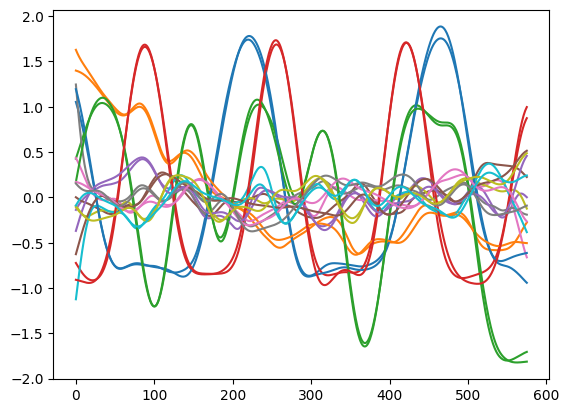

In [231]:
plt.plot(denoised_orig[k].T)
plt.plot(denoised_rec[k].T)

In [57]:
13.2406695/res[1]

/tmp/ipykernel_9500/3347500641.py:1: RuntimeWarning: divide by zero encountered in double_scalars
  13.2406695/res[1]


inf

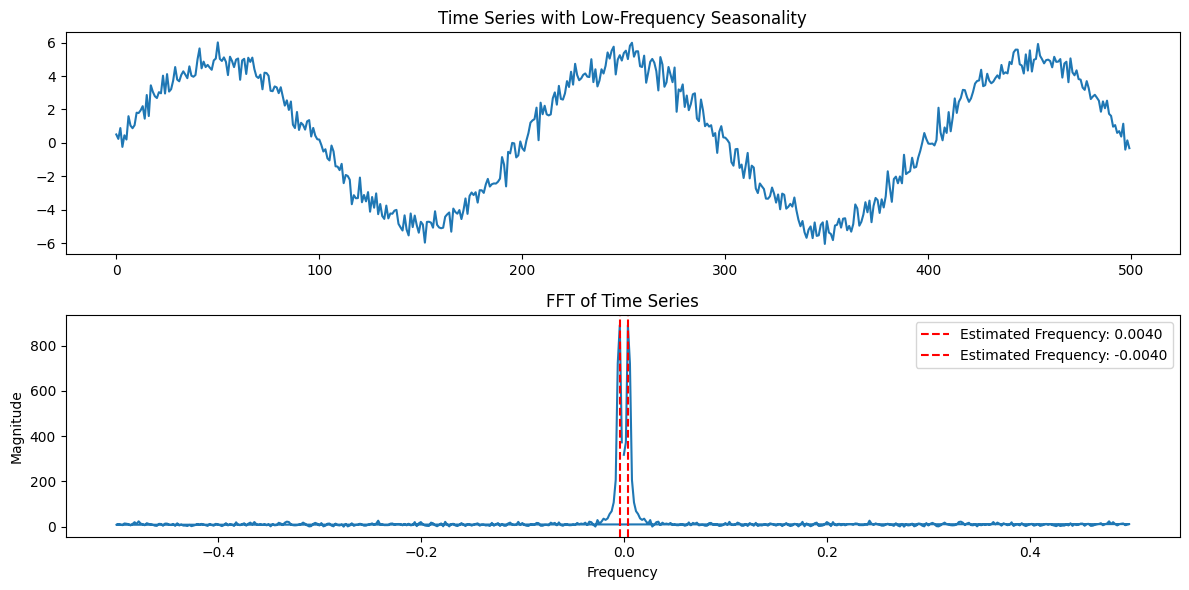

In [140]:
from scipy.signal import find_peaks

# Create a time series with low-frequency seasonality
n = 500
t = np.arange(n)
frequency = 0.005  # Low-frequency seasonality
seasonality = 5 * np.sin(2 * np.pi * frequency * t)
noise = np.random.normal(0, 0.5, n)
time_series = seasonality + noise

# Compute the FFT
fft_result = np.fft.fft(time_series)
sampling_frequency = 1  # Assuming unit sampling frequency
frequencies = np.fft.fftfreq(n, d=1 / sampling_frequency)

# Identify the peaks in the FFT magnitude plot
peaks, _ = find_peaks(np.abs(fft_result), 600)

# Extract corresponding frequencies
peak_frequencies = frequencies[peaks]

# Plot the time series and the estimated frequencies
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(t, time_series)
plt.title('Time Series with Low-Frequency Seasonality')

plt.subplot(2, 1, 2)
plt.plot(frequencies, np.abs(fft_result))
plt.title('FFT of Time Series')
plt.xlabel('Frequency')
plt.ylabel('Magnitude')

# Plot the estimated frequencies
for freq in peak_frequencies:
    plt.axvline(x=freq, color='r', linestyle='--', label=f'Estimated Frequency: {freq:.4f}')
plt.legend()

plt.tight_layout()
plt.show()

In [58]:
11.27865253/res[0]

1.0741573838095237

In [133]:
Origin_norm, REC_norm, _ = rebuild_TS(v, train_data, args, keep_norm=True)
denoised = denoise_data(Origin_norm.cpu())

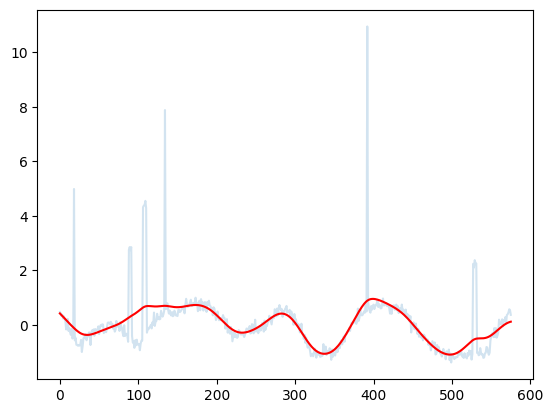

In [134]:
plt.plot(Origin_norm[1,0], alpha=0.2)
plt.plot(denoised[1,0], "r-")

In [29]:
find_freqs_p(denoised[1,0],2)
arr[1]

NameError: name 'find_freqs_p' is not defined

In [15]:
def find_freqs(denoised, n):
    freqs_w = []
    i = 0
    sample_rate = 24*12*7
    N=len(denoised)
    print(denoised.shape)
    while len(freqs_w) < n:
        i += 1
        X = sf.rfft(denoised) #/ N
        freqs = sf.rfftfreq(n=N, d=1/sample_rate)
#         print(X.shape)

        max_freq_ind = np.argpartition(np.abs(X), -i)[-i:]
#         print(freqs[max_freq_ind])
        freqs_w = filter_close_values(freqs[max_freq_ind], 0.2)
#         print(freqs_w)
    
        
    results = [fs % 14 for fs in freqs_w]
    return np.array(results, dtype=np.float64)

In [16]:
def get_frequencies_per_week_long(v, train_data, args, n):
#     data = train_data.dataset.data
#     shape = data.shape[:-1]
#     N = data.shape[-1]

    Origin_norm, REC_norm, _ = rebuild_TS_non_overlapping(v, train_data, args, keep_norm=True)
    denoised = denoise_data(REC_norm.T.cpu())


    
    freqs = np.empty((args.n_channels, n))
    for i, fs in enumerate(freqs):
        fs = find_freqs(denoised[i], n)
    

#     print(freqs_w)
#     print([fs % 14 for fs in freqs_w])

    return fs

In [253]:
def get_frequencies_per_week(v, train_data, args, n):

    Origin_norm, REC_norm, _ = rebuild_TS(v, train_data, args, keep_norm=True)
    denoised = denoise_data(Origin_norm.cpu())


    freqs = np.empty((denoised.shape[0], args.n_channels, n))
    for i, sample in enumerate(freqs):
#         print(i)
        for j, fs in enumerate(sample):
            fs = find_freqs_p(denoised[i, j], n)
            freqs[i,j] = fs
    return freqs

In [256]:
arr.shape

(5000, 5)

In [254]:
fs = get_frequencies_per_week(v, train_data, args, n=5)
x, params, e_params = X.parameters()
frs = e_params["Seasonality"]["frequency_per_week"]
arr = np.array(frs)
arr[0]

# print(fs)
# frs

array([11.07251433, 13.40359696, 11.66289372, 13.41735455,  9.39057982])

In [19]:
fs = get_frequencies_per_week_long(v, train_data_long, args, n=3)
x_long, params_long, e_params_long = X_long.parameters()
frs = e_params_long["Seasonality"]["frequency_per_week"][0]
print(fs)
frs

(83520,)
input [13.73448276 13.75862069]
13.758620689655174 13.734482758620691
0.024137931034482918
input [13.15517241 13.73448276 13.75862069]
13.734482758620691 13.155172413793105
0.5793103448275865
13.758620689655174 13.734482758620691
0.024137931034482918
input [13.15517241 13.17931034 13.73448276 13.75862069]
13.179310344827588 13.155172413793105
0.024137931034482918
13.734482758620691 13.155172413793105
0.5793103448275865
13.758620689655174 13.734482758620691
0.024137931034482918
input [12.52758621 13.15517241 13.17931034 13.73448276 13.75862069]
13.155172413793105 12.527586206896553
0.6275862068965523
13.179310344827588 13.155172413793105
0.024137931034482918
13.734482758620691 13.155172413793105
0.5793103448275865
13.758620689655174 13.734482758620691
0.024137931034482918
[12.52758621 13.15517241 13.73448276]


array([13.74697078, 12.51960769, 13.16560254])

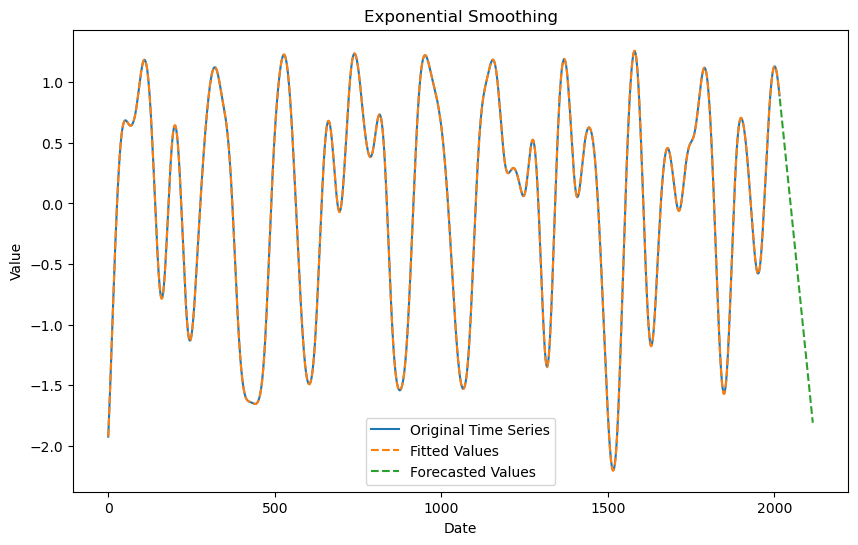

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Create an example time series dataset
np.random.seed(0)
n = 100
t = np.arange(n)
noise = np.random.normal(0, 0.5, n)
time_series = 2 * t + 10 * np.sin(0.1 * t) + noise

# Convert the data to a pandas Series (with dates) for time-based analysis
# date_range = pd.date_range(start='2023-01-01', periods=, freq='D')
ts_data = pd.Series(denoised[0][:288*7])

# Apply exponential smoothing
exponential_smoothing = sm.tsa.ExponentialSmoothing(ts_data, trend='add', seasonal=None)
fitted_model = exponential_smoothing.fit()

# Forecast using the fitted model
forecast = fitted_model.forecast(steps=100)  # Forecast the next 10 time points

# Plot the original time series and the forecasted values
plt.figure(figsize=(10, 6))
plt.plot(ts_data, label='Original Time Series')
plt.plot(fitted_model.fittedvalues, label='Fitted Values', linestyle='--')
plt.plot(forecast, label='Forecasted Values', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.title('Exponential Smoothing')
plt.show()

In [135]:
data = train_data_long.dataset.data
data.numpy().shape

(2, 83865)

/tmp/ipykernel_9355/464481837.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([f'{a}' for a in range(days+1)])


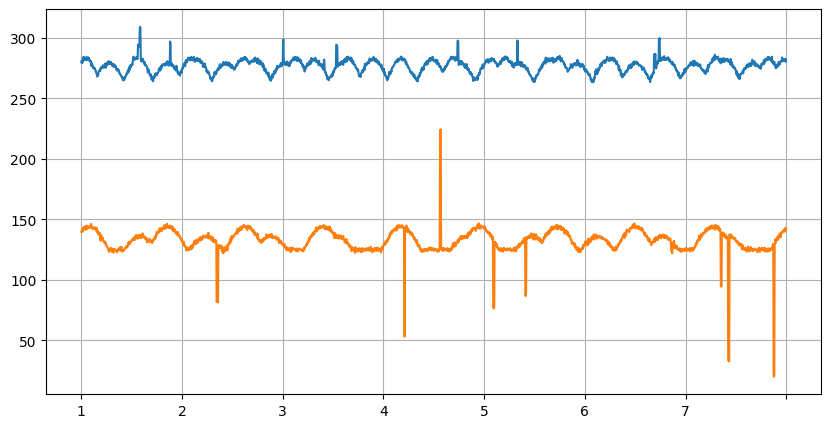

In [136]:
from matplotlib.ticker import MultipleLocator

days = 7
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(data.T[:288*days])
plt.grid(True)
x_locator = MultipleLocator(base=288)
ax.xaxis.set_major_locator(x_locator)
ax.set_xticklabels([f'{a}' for a in range(days+1)])
# ax.xaxis.set_major_formatter('{:.0f}'.format)
plt.show()

In [137]:
mean_global = data.mean(dim=1, keepdim=True)
std_global = data.std(dim=1, keepdim=True)
for i, (data, label, norm) in enumerate(train_data_long):
    denorm_data = revert_standarization(data, norm)
    mean_window = denorm_data.mean(dim=-1)
    std_window = denorm_data.std(dim=-1)

TypeError: only integer tensors of a single element can be converted to an index

In [459]:
x_long, params_long, e_params_long = X_long.parameters()
frs = e_params_long["Seasonality"]["frequency_per_week"][0]
frs

array([ 9.12847645,  8.751179  , 11.507779  ])

In [402]:
e_params_long["Seasonality"]["amplitude"][0]

array([18,  6])

In [14]:
def denoise_data(data):
    denoised = np.empty_like(data)
    for i, d in enumerate(data):
        denoised[i] = denoise(d.unsqueeze(0).cpu())
    return denoised

Origin_norm, REC_norm, _ = rebuild_TS_non_overlapping(v, train_data_long, args, keep_norm=True)
denoised = denoise_data(Origin_norm.T.cpu())

In [461]:
def filter_close_values(input_list, threshold):
    if len(input_list) <= 1:
        return input_list  # Nothing to filter if the list has 0 or 1 element

    input_list.sort()  # Sort the list in ascending order
    filtered_list = [input_list[0]]

    for value in input_list[1:]:
        if abs(value - filtered_list[-1]) > threshold and (abs(value % filtered_list) > threshold).all():
            filtered_list.append(value)

    return filtered_list

In [1058]:
denoised.shape

(4000, 1, 8064)

[0.]
Dominant frequencies: []


ValueError: x and y must have same first dimension, but have shapes (1,) and (8064,)

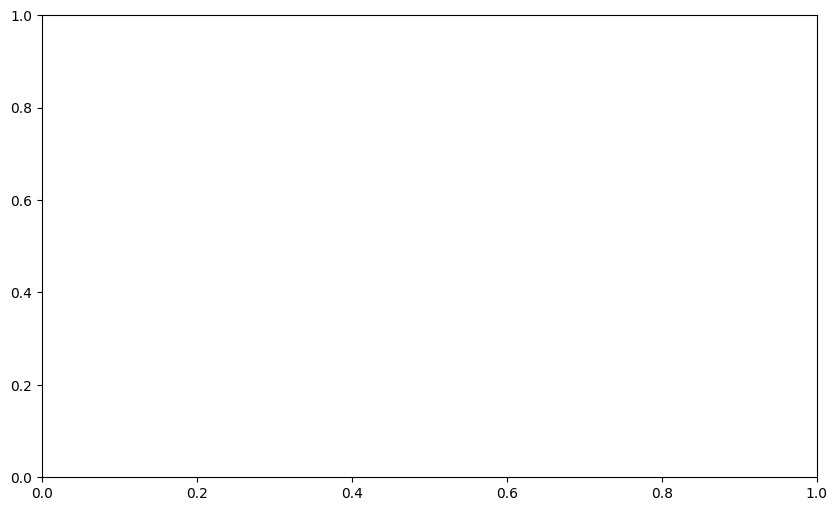

In [1059]:
from scipy.signal import find_peaks

# # Sample data with two seasonalities
n = len(denoised[0]) # 400
sampling_rate  = 1
# t = np.arange(0, n)
# sampling_rate = 10  # Increase the sampling rate
# t = t / sampling_rate  # Adjust the time vector accordingly
# time_series = 5 * np.sin(0.1 * t * 2 * np.pi) + 2 * np.sin(0.4 * t * 2 * np.pi)

# Compute the FFT
fft_result = np.fft.fft(denoised[0,0])

# Calculate frequencies
frequencies = np.fft.fftfreq(n, d=1/(24*12*7))
print(frequencies)

# Find peaks in the FFT magnitude
peaks, _ = find_peaks(np.abs(fft_result), height=np.max(fft_result))  # Adjust the height threshold as needed

# Extract corresponding frequencies
peak_frequencies = np.abs(frequencies[peaks])

print("Dominant frequencies:", peak_frequencies)

# Plot the FFT
plt.figure(figsize=(10, 6))
plt.plot(frequencies, np.abs(fft_result))
plt.title('FFT of Time Series')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.grid()
plt.show()

In [817]:
1008/(24*12*7)

0.5

[37  0]
[1002.93164 3740.3425 ]
[   0.      0.25    0.5  ... 1007.5  1007.75 1008.  ]


<StemContainer object of 3 artists>

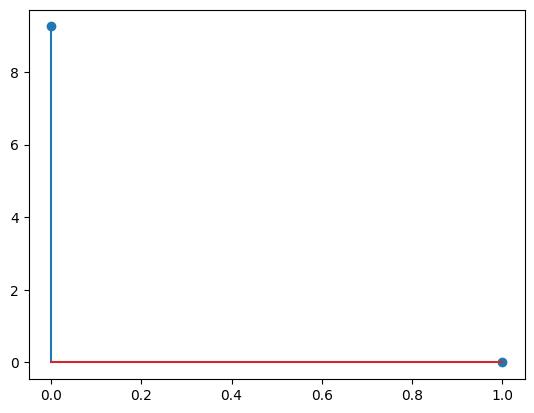

In [1060]:
days = 7
# N = 288 * days
N=len(denoised[0,0])
n=2
results = []
i = 0
while len(results) < n:
    i += 1
    X = sf.rfft(denoised[0,0]) #/ N
    freqs = sf.rfftfreq(n=N, d=1/(24*12*7))
    
    max_freq_ind = np.argpartition(np.abs(X), -i)[-i:]
#     results = filter_close_values(freqs[max_freq_ind], 0.2)
    results = freqs[max_freq_ind]
print(max_freq_ind)
print(abs(X[max_freq_ind]))
print((freqs))
# print(results)
# print([result%14 for result in results])

plt.stem(freqs[max_freq_ind])
# frs

In [809]:
def get_frequencies_per_week(v, train_data, args, n):
    
    Origin_norm, REC_norm, _ = rebuild_TS_non_overlapping(v, train_data, args, keep_norm=True)
    denoised = denoise_data(Origin_norm.T.cpu())

    N=len(denoised[0])
    freqs_w = []
    i = 0
    while len(freqs_w) < n:
        i += 1
        X = sf.rfft(denoised[0]) #/ N
        freqs = sf.rfftfreq(n=N, d=1/(24*12*7))

        max_freq_ind = np.argpartition(np.abs(X), -i)[-i:]
        freqs_w = filter_close_values(freqs[max_freq_ind], 0.2)

#     print(freqs_w)
#     print([fs % 14 for fs in freqs_w])
    results = [fs % 14 for fs in freqs_w]

    return results

In [15]:
get_frequencies_per_week(v, train_data_long, args, n=3)
x_long, params_long, e_params_long = X_long.parameters()
frs = e_params_long["Seasonality"]["frequency_per_week"][0]
frs

[8.810344827586208, 10.210344827586209, 13.493103448275864]
[8.810344827586208, 10.210344827586209, 13.493103448275864]


array([ 8.82219493, 13.48370278, 10.20135647])

In [204]:
N/(288*7)

1.0

(1009,)
[ 8  6  7 11 15]
[255.40695 298.44864 699.44946 662.7711  397.8458 ]
[112.  84.  98. 154. 210.]


array([ 9.40703251, 10.85850522, 10.41877301,  7.38420925])

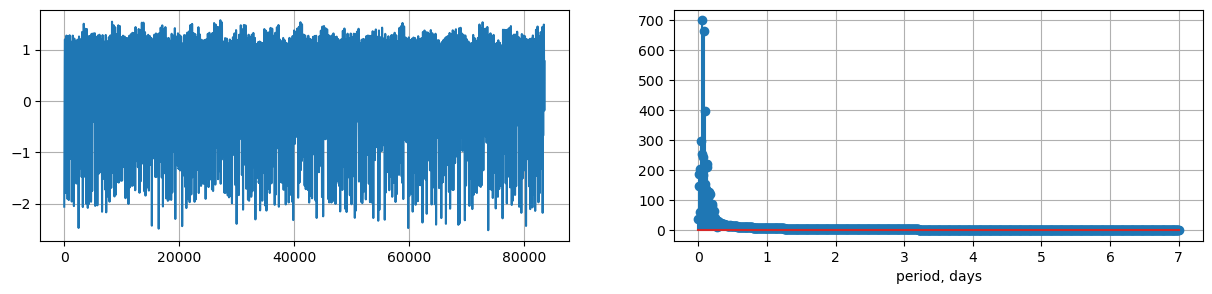

In [220]:
import scipy.fft as sf
import matplotlib.ticker as tck

days = 7
N = 288 * days
# N = denoised.shape[-1]
X = sf.rfft(denoised[0][:N]) #/ N
freqs = sf.rfftfreq(n=N, d=1/(days*2))

print(X.shape)
# Plot signal
fig, axes = plt.subplots(figsize=(15,3), ncols=2)
ax=axes[0]
ax.plot(denoised[0])
# ax.xaxis.set_major_locator(tck.MultipleLocator(50))
ax.grid()

# # Plot DFT
ax=axes[1]
extent = 288*7 -1#288*7#N
ax.set_xlabel('period, days')
# ax.stem(freqs[:extent], abs(X[:extent]))
ax.stem(freqs, abs(X))

# x_locator = MultipleLocator(base=288)
# ax.xaxis.set_major_locator(x_locator)
# ax.set_xticklabels([f'{a}' for a in range(days+1)])
# ticks = ax.get_xticks()
# ax.set_xticklabels([f'{a}' for a in range(1000)])
# ax.invert_xaxis()
ax.grid()
np.set_printoptions(suppress=True)

# print(np.argmax(X))
n=5
max_freq_ind = np.argpartition(np.abs(X), -n)[-n:]
print(max_freq_ind)
print(abs(X[max_freq_ind]))
print(freqs[max_freq_ind]*N)
frs

In [571]:
Origin_norm.shape

torch.Size([83520, 1])

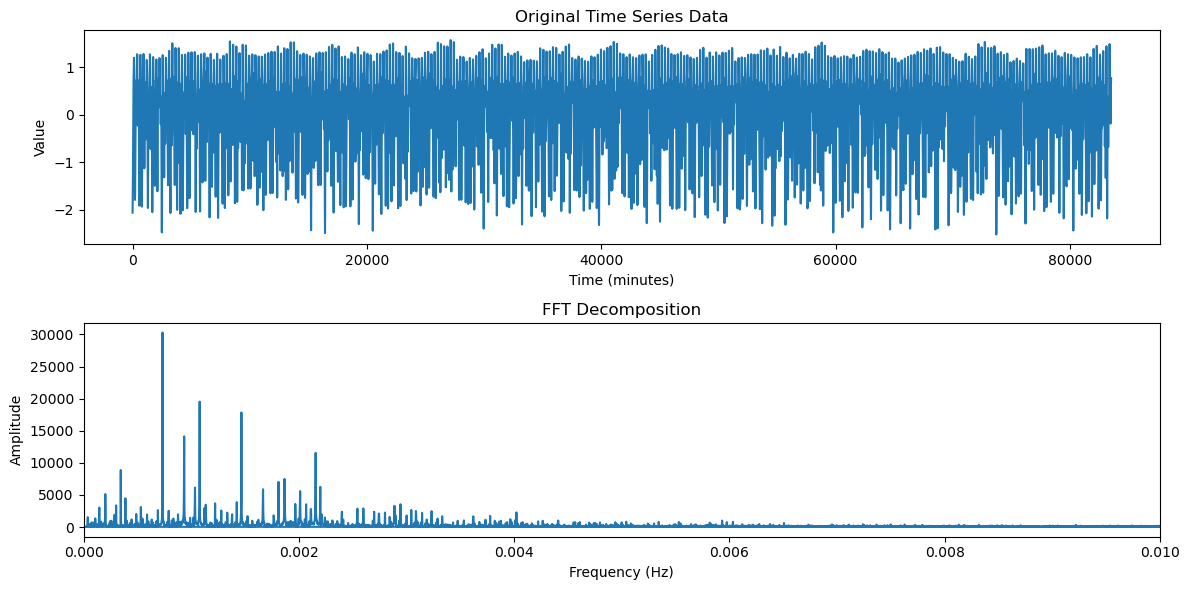

In [221]:
# Define your time series data with a 3-day seasonality
sampling_rate = 5  # 5 minutes between data points
num_points = Origin_norm.shape[0]  # Number of data points (assuming 5-minute intervals in a day)

# Create a time vector in minutes
time = np.arange(0, num_points)# * sampling_rate

# # Create a synthetic time series with a 3-day seasonality
# seasonality_freq = 1 / (3 * 24 * 60)  # Frequency in Hz (3 days in minutes)
# amplitude = 10  # Amplitude of the seasonality
# noise = np.random.normal(0, 1, num_points)  # Add some random noise
# data = amplitude * np.sin(2 * np.pi * seasonality_freq * time) + noise

# Perform FFT on the data
fft_result = np.fft.fft(Origin_norm[:,0].cpu())
frequencies = np.fft.fftfreq(denoised.shape[-1], d=sampling_rate)

# Plot the original data
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(time, denoised[0])
plt.title("Original Time Series Data")
plt.xlabel("Time (minutes)")
plt.ylabel("Value")

# Plot the FFT results
plt.subplot(2, 1, 2)
plt.plot(frequencies, np.abs(fft_result))
plt.title("FFT Decomposition")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.xlim(0, 0.01)  # Limit the x-axis to relevant frequencies

plt.tight_layout()
plt.show()


In [222]:
N = 10  # Adjust N as needed
max_amplitude_indices = np.argpartition(np.abs(fft_result), -N)[-N:]
# Get the corresponding frequency in Hertz
max_frequencies = frequencies[max_amplitude_indices]
positive_frequencies = max_frequencies[max_frequencies > 0]
print("Dominant Frequency:", positive_frequencies, "Hz")
np.set_printoptions(suppress=True)



Dominant Frequency: [0.00215517 0.00093391 0.00107759 0.00073276 0.00146552] Hz


In [223]:
np.sort(7 / (positive_frequencies * 24 * 60))

array([2.25555556, 3.31699346, 4.51111111, 5.20512821, 6.63398693])

In [224]:
np.sort(frs)

array([ 7.38420925,  9.40703251, 10.41877301, 10.85850522])

In [215]:
x_long, params_long, e_params_long = X_long.parameters()
frs = e_params_long["Seasonality"]["frequency_per_week"][0]
frs/(7*288)

array([0.00466619, 0.00538616, 0.00516804, 0.0036628 ])

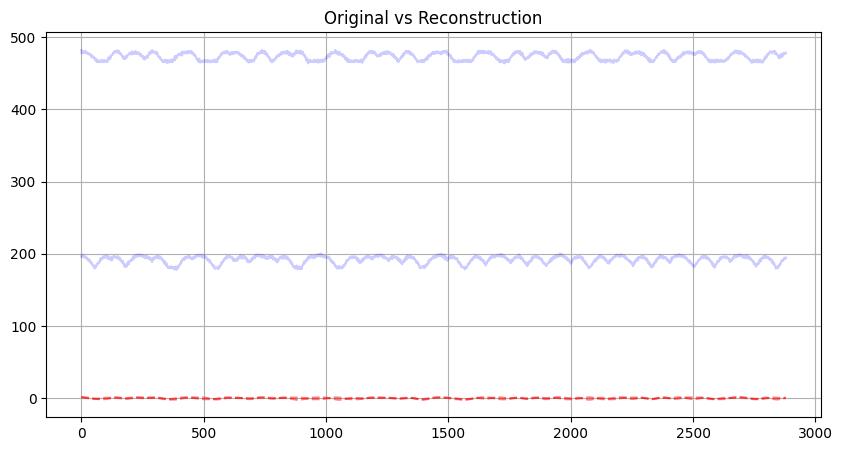

In [217]:
plot_rec(data.T[:args.L*5], denoised.T[:args.L*5])

In [214]:
denoised.shape

(2, 83520)

In [298]:
r = np.correlate(denoised[0][:args.L*20], denoised[0][:args.L], mode='full')[args.L*10:]
print(denoised.shape, r.shape)

(2, 83520) (6335,)


Text(0.5, 0, 'Lag (samples)')

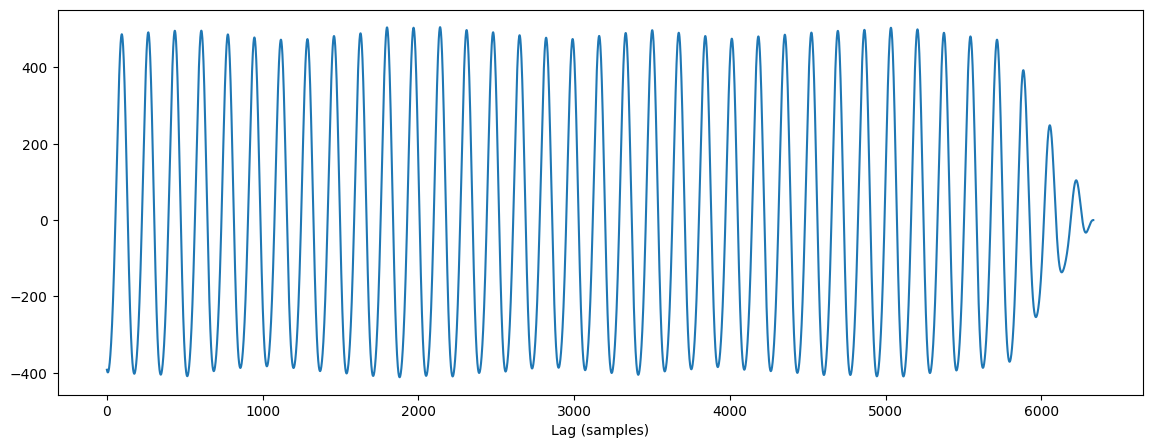

In [299]:
plt.figure(figsize=(14, 5))
plt.plot(r)
plt.xlabel('Lag (samples)')
# plt.xlim(0, 10000)

In [313]:
idx=np.argpartition(r, -10)[-10:]

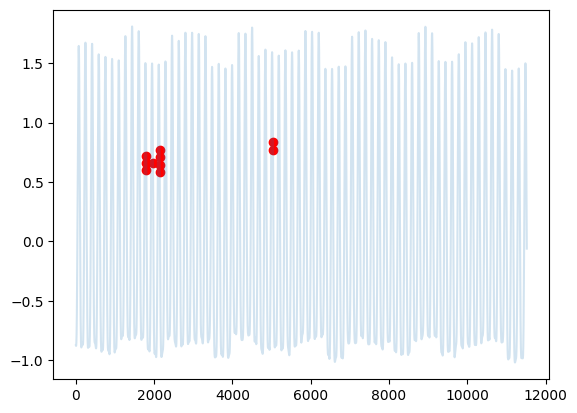

In [314]:
x= np.arange(len(denoised[0][:args.L*20]))
y = denoised[0][:args.L*20]
plt.plot(y, alpha=0.2)
plt.scatter(x[idx], y[idx], color='red', label='Dot at Index {}'.format(2901))


In [10]:
from statsmodels.graphics.tsaplots import plot_acf

In [304]:
def autocorr1(x,lags):
    '''numpy.corrcoef, partial'''

    corr=[1. if l==0 else np.corrcoef(x[l:],x[:-l])[0][1] for l in lags]
    return np.array(corr)

def autocorr2(x,lags):
    '''manualy compute, non partial'''

    mean=np.mean(x)
    var=np.var(x)
    xp=x-mean
    corr=[1. if l==0 else np.sum(xp[l:]*xp[:-l])/len(x)/var for l in lags]

    return np.array(corr)

def autocorr3(x,lags):
    '''fft, pad 0s, non partial'''

    n=len(x)
    # pad 0s to 2n-1
    ext_size=2*n-1
    # nearest power of 2
    fsize=2**np.ceil(np.log2(ext_size)).astype('int')

    xp=x-np.mean(x)
    var=np.var(x)

    # do fft and ifft
    cf=np.fft.fft(xp,fsize)
    sf=cf.conjugate()*cf
    corr=np.fft.ifft(sf).real
    corr=corr/var/n

    return corr[:len(lags)]

def autocorr4(x,lags):
    '''fft, don't pad 0s, non partial'''
    mean=x.mean()
    var=np.var(x)
    xp=x-mean

    cf=np.fft.fft(xp)
    sf=cf.conjugate()*cf
    corr=np.fft.ifft(sf).real/var/len(x)

    return corr[:len(lags)]

def autocorr5(x,lags):
    '''numpy.correlate, non partial'''
    mean=x.mean()
    var=np.var(x)
    xp=x-mean
    corr=np.correlate(xp,xp,'full')[len(x)-1:]/var/len(x)

    return corr[:len(lags)]

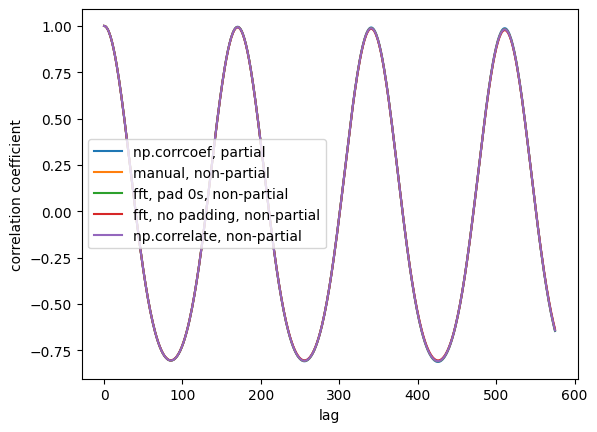

In [305]:
y=[28,28,26,19,16,24,26,24,24,29,29,27,31,26,38,23,13,14,28,19,19,\
            17,22,2,4,5,7,8,14,14,23]
y=np.array(y).astype('float')

# lags=range(15)
lags=range(args.L)
fig,ax=plt.subplots()

for funcii, labelii in zip([autocorr1, autocorr2, autocorr3, autocorr4,
    autocorr5], ['np.corrcoef, partial', 'manual, non-partial',
        'fft, pad 0s, non-partial', 'fft, no padding, non-partial',
        'np.correlate, non-partial']):

    cii=funcii(denoised[0],lags)
#     print(labelii)
#     print(cii)
    ax.plot(lags,cii,label=labelii)

ax.set_xlabel('lag')
ax.set_ylabel('correlation coefficient')
ax.legend()
plt.show()

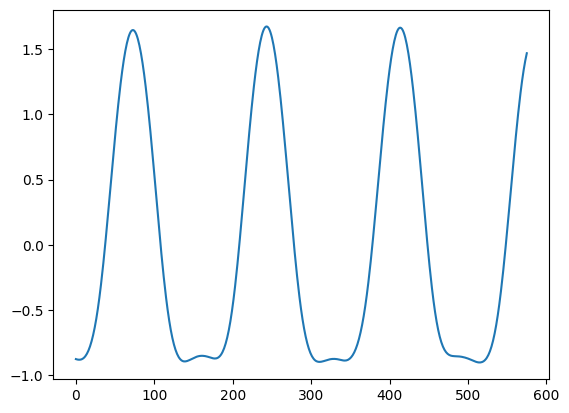

In [306]:
plt.plot(denoised[0][:576])

In [307]:
?plot_acf

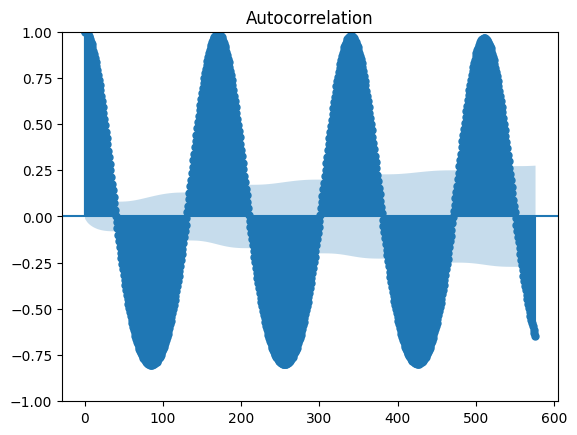

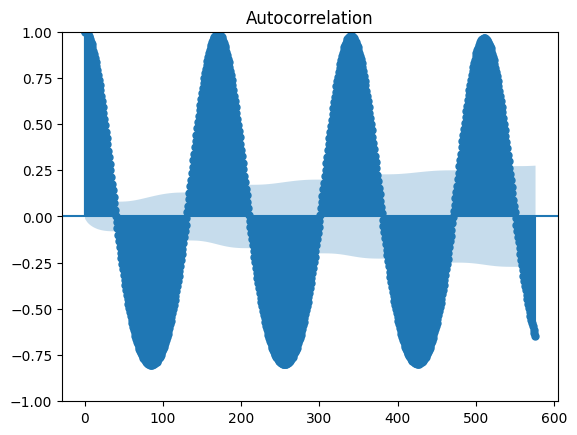

In [309]:
plot_acf(denoised[0][:576*40], lags=576*1)

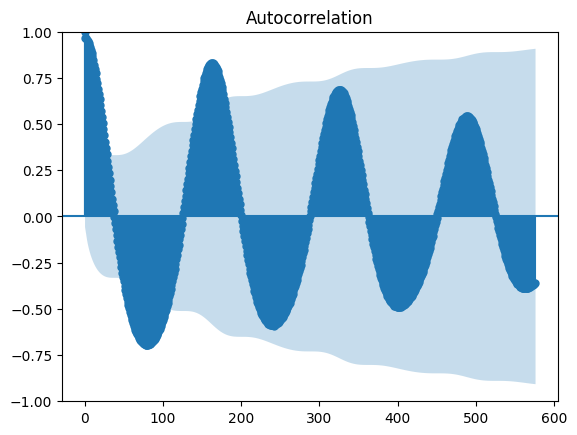

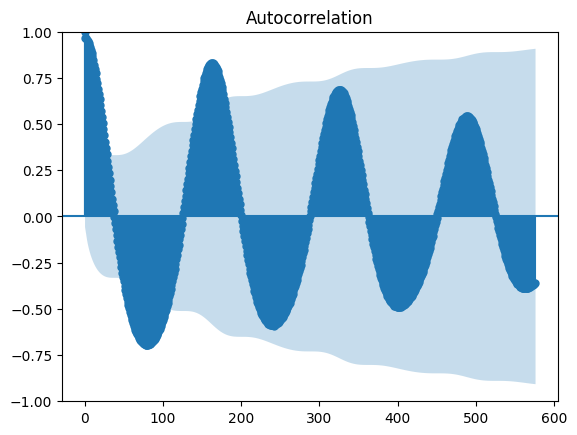

In [13]:
plot_acf(Origin_norm[0,0][:576*2].cpu(), lags=576*1)

In [311]:
fft_signal, freqs = fft_freq(denoised[0][:2000], args.step*60, 10)

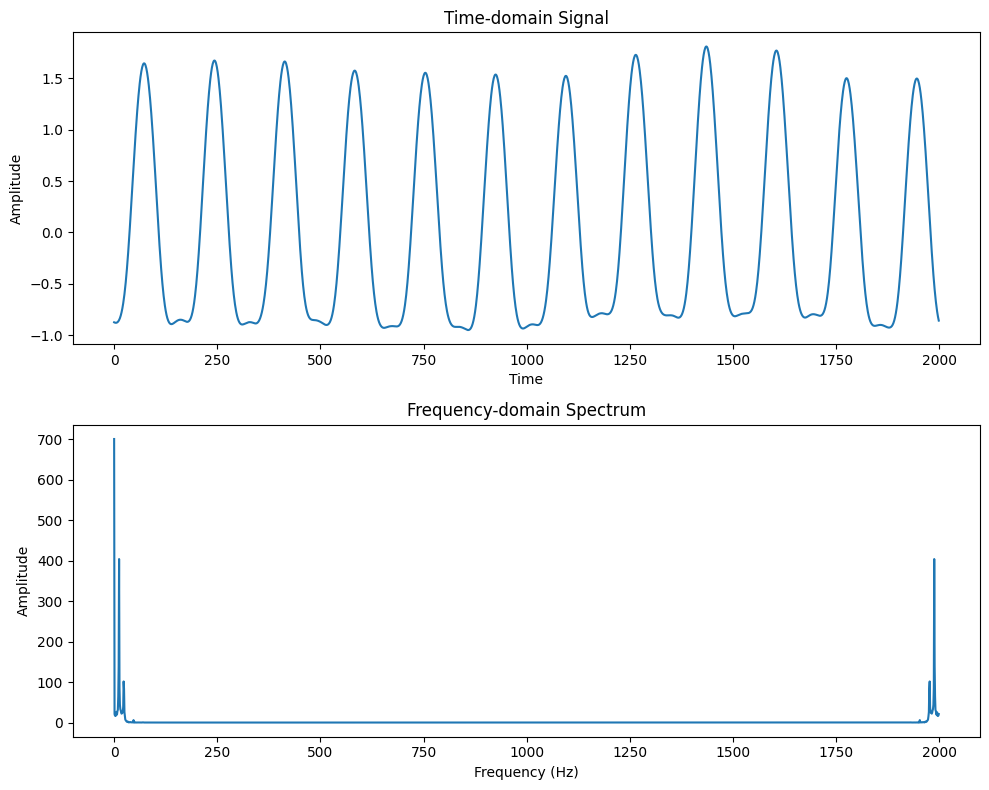

Dominant Frequency: [ 0.     1.728 -1.728 -1.584  1.584  3.312 -3.312  1.872 -1.872 -3.456
  3.456 -1.44   1.44  -2.016  2.016  3.168 -3.168  2.16  -2.16   1.296] Hz
Dominant Amplitude: [700.55273  403.97562  403.97562  139.17421  139.17421  101.54321
 101.54321   85.815414  85.815414  83.31932   83.31932   65.075
  65.075     44.328068  44.328068  38.753223  38.753223  33.267147
  33.267147  31.328114]


In [312]:
plot_fft(denoised[0][:2000], fft_signal, freqs)

In [58]:
import tsfel
# Retrieves a pre-defined feature configuration file to extract all available features
cfg = tsfel.get_features_by_domain("spectral")

# Extract features
X = tsfel.time_series_features_extractor(cfg, data.T, fs=1/5, window_size=args.L, overlap=0)
# Y = tsfel.time_series_features_extractor(cfg, denoised)

*** Feature extraction started ***



*** Feature extraction finished ***


In [51]:
?tsfel.time_series_features_extractor

In [59]:
import pandas as pd
pd.options.display.max_rows = None
pd.set_option('display.float_format', lambda x: f'{x:.3f}')
# X.T.columns = ["val"]
X.T

,0,1,2,3,4,5,6,7,8,9,...,135,136,137,138,139,140,141,142,143,144
0_FFT mean coefficient_0,122.461,170.533,197.777,246.101,192.077,194.615,178.720,154.806,105.768,59.161,...,64.599,40.775,5.530,0.841,2.509,31.486,80.275,116.943,123.303,211.849
0_FFT mean coefficient_1,2294.586,1919.005,1628.834,1770.980,2006.093,2028.584,2293.307,2326.922,2873.659,3099.236,...,2073.820,4308.808,5258.072,4556.608,4382.634,5537.316,5216.296,5475.068,4506.649,5557.896
0_FFT mean coefficient_10,206.542,177.248,418.546,241.207,187.146,138.373,65.304,140.635,66.248,97.978,...,43.072,94.134,82.454,138.860,108.425,114.099,148.196,188.350,314.470,362.180
0_FFT mean coefficient_100,13.760,0.756,15.874,11.442,6.084,10.851,0.773,17.978,3.138,1.843,...,3.459,1.446,23.576,4.086,2.067,5.253,25.649,13.319,6.789,0.022
0_FFT mean coefficient_101,2.716,31.314,5.477,6.307,12.924,22.865,1.029,2.290,0.043,25.530,...,1.219,10.820,9.355,1.289,3.839,3.241,0.101,6.360,4.505,0.785
0_FFT mean coefficient_102,13.267,6.863,1.896,14.933,0.365,9.202,0.603,13.618,1.811,1.087,...,13.524,3.012,14.845,6.957,9.621,7.470,32.131,29.650,37.056,10.615
0_FFT mean coefficient_103,19.452,16.515,7.418,13.663,22.721,5.541,8.297,14.212,1.592,2.086,...,4.487,25.223,9.046,14.769,4.483,12.003,17.985,3.155,32.542,6.361
0_FFT mean coefficient_104,10.780,14.428,8.753,18.674,3.711,14.249,6.019,14.587,11.504,10.859,...,34.722,6.166,4.080,16.628,22.754,17.551,12.348,17.467,5.384,12.883
0_FFT mean coefficient_105,3.820,0.091,23.638,0.452,3.178,3.975,16.334,11.244,3.990,6.382,...,15.126,7.384,20.578,6.160,23.142,3.922,5.722,24.407,5.625,6.365
0_FFT mean coefficient_106,2.482,2.492,0.690,0.249,21.142,0.677,1.204,2.903,12.639,25.723,...,9.081,1.605,5.073,31.577,15.845,15.218,9.277,2.572,13.726,8.888


In [169]:
class identifier(nn.Module):
    def __init__(self, input_size, num_layers, output_size, slope):
        super(identifier, self).__init__()   
        
        self.input_size =  input_size      
        self.num_layers = num_layers
        self.output_size = output_size
        self.lin_layers = nn.ModuleList()
        self.n = 1
        
        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.uniform_(m.weight, a=0.0, b=1.0)
                m.bias.data.fill_(0.01)
                
        # CNN Layers that double the channels each time
        for i in range(0, num_layers):
            
            if i == num_layers -1:
                self.lin_layers.append(nn.Linear(self.input_size, output_size))
                self.lin_layers.append(nn.LeakyReLU(slope, True))
#                 self.lin_layers.append(nn.BatchNorm1d(self.n))
                self.input_size = self.input_size // (2 ** num_layers)
            else:
                print(self.input_size, self.input_size * 2)
                self.lin_layers.append(nn.Linear(self.input_size, self.input_size * 2))
                self.lin_layers.append(nn.LeakyReLU(slope, True))
#                 self.lin_layers.append(nn.BatchNorm1d(self.n))
                self.input_size = self.input_size * 2
        
        self.lin_layers.apply(init_weights)
            
         
    def forward(self, x):
#         print("x input", x.shape)
        x_shape = x.shape
        x = x.view(x.size(0), -1).unsqueeze(1)
#         print("x before lin", x.shape)
        for i, lin in enumerate(self.lin_layers):
            x = lin(x)        
#         print("x after lin", x.shape)
        x = x.squeeze(1).view(x_shape[0], -1)
#         print("x out", x.shape)
        return x

In [199]:
def train_identifier_modified(id_model, train_loader, optimizer, device, epoch):
    id_model.train()
    labels_size = id_model.output_size
    for p in id_model.parameters():
        p.requires_grad = True
    train_loss = 0
    y_pred = torch.empty((0, labels_size), device=device)
    for batch_idx, (data, label, norm) in enumerate(train_loader):
#         print(data.shape)

        data = data.to(device)
        label = label[:,:,1].to(device)
        optimizer.zero_grad()
#         data = data.view(-1, data.shape[2], data.shape[3])
        
        identified = id_model(data)
#         print(identified.shape)
#         print(torch.mean(identified, dim=0))
#         print(label.shape)
        
#         loss = F.mse_loss(torch.mean(identified, dim=0), labels, reduction='mean')
        loss = F.mse_loss(identified, label, reduction='mean')
#         print(loss)
        # print(x_rec.shape)
        # print(data[:, :, 0].shape)
        loss.backward()

        optimizer.step()
        train_loss += loss.item()
        y_pred = torch.cat((y_pred, identified), dim = 0) 
        if batch_idx % 1000 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                       100. * batch_idx / len(train_loader), loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))

    return y_pred

def test_identifier_modified(id_model, train_loader, optimizer, device, epoch):
    id_model.train()
    for p in id_model.parameters():
        p.requires_grad = False
    train_loss = 0

    for batch_idx, (data, label, norm) in enumerate(train_loader):

        data = data.to(device)
        label = label[:,:,1].to(device)
#         optimizer.zero_grad()
#         data = data.view(-1, data.shape[2], data.shape[3])
        
        identified = id_model(data)
#         print(identified.shape)
#         print(torch.mean(identified, dim=0))
#         print(label.shape)
#         print(data.shape)
        
#         loss = F.mse_loss(torch.mean(identified, dim=0), labels, reduction='mean')
        loss = F.mse_loss(identified, label, reduction='mean')
#         print(loss)
        # print(x_rec.shape)
        # print(data[:, :, 0].shape)
#         loss.backward()

#         optimizer.step()
        train_loss += loss.item()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                       100. * batch_idx / len(train_loader), loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))
#     print(batch_idx)

    return identified

In [197]:
n = 1 * 4 * 2 * 41
print(n*1*30)
id_mlp = identifier(input_size=576, num_layers=1, output_size=4, slope=0)
id_mlp = id_mlp.to(args.device)

id_mlp_opt = optim.Adam(id_mlp.parameters(), lr = 0.01)

9840


In [200]:
for epoch in range(1,10):
    y_train_pred_mlp = train_identifier_modified(id_mlp,train_data, id_mlp_opt, args.device, epoch)
y_test_pred_mlp = test_identifier_modified(id_mlp,test_data, id_mlp_opt, args.device, epoch)

Train Epoch: 1 [0/4000 (0%)]	Loss: 56.766533
====> Epoch: 1 Average loss: 60.8175
Train Epoch: 2 [0/4000 (0%)]	Loss: 56.313625
====> Epoch: 2 Average loss: 60.4886
Train Epoch: 3 [0/4000 (0%)]	Loss: 55.959698
====> Epoch: 3 Average loss: 60.2199
Train Epoch: 4 [0/4000 (0%)]	Loss: 55.679352
====> Epoch: 4 Average loss: 59.9868
Train Epoch: 5 [0/4000 (0%)]	Loss: 55.445702
====> Epoch: 5 Average loss: 59.7705
Train Epoch: 6 [0/4000 (0%)]	Loss: 55.237358
====> Epoch: 6 Average loss: 59.5727
Train Epoch: 7 [0/4000 (0%)]	Loss: 55.047272
====> Epoch: 7 Average loss: 59.3938
Train Epoch: 8 [0/4000 (0%)]	Loss: 54.848492
====> Epoch: 8 Average loss: 59.2279
Train Epoch: 9 [0/4000 (0%)]	Loss: 54.669796
====> Epoch: 9 Average loss: 59.0776
Train Epoch: 9 [0/500 (0%)]	Loss: 66.506424
====> Epoch: 9 Average loss: 68.9839


In [207]:
for batch_idx, (data, label, norm) in enumerate(train_data):

    data = data.to(args.device)
    label = label[:,:,1].to(args.device)
#         optimizer.zero_grad()
#         data = data.view(-1, data.shape[2], data.shape[3])

    identified = id_mlp(data)
    print(identified[0], label[0])

tensor([153.8879,  -0.0000,   6.9853,   3.4626], device='cuda:0') tensor([373.0000,   1.0000,  12.3177,   8.3686], device='cuda:0')
tensor([45.6966, -0.0000, -0.0000, 11.7521], device='cuda:0') tensor([96.0000,  1.0000,  7.8325, 11.1604], device='cuda:0')
tensor([177.7629,   1.6209,  -0.0000,   8.9965], device='cuda:0') tensor([394.0000,   1.0000,   7.1965,  13.0473], device='cuda:0')
tensor([186.5321,   0.2891,   0.5423,   8.1666], device='cuda:0') tensor([469.0000,   1.0000,  11.8901,  13.8836], device='cuda:0')
tensor([-0.0000, -0.0000, 14.8344, -0.0000], device='cuda:0') tensor([133.0000,   1.0000,  13.0515,  13.6680], device='cuda:0')
tensor([291.0201,   0.7340,  -0.0000,  10.4569], device='cuda:0') tensor([377.0000,   1.0000,   7.3017,  11.3262], device='cuda:0')
tensor([-0.0000, -0.0000, 10.8225,  8.2450], device='cuda:0') tensor([217.0000,   1.0000,   8.8992,   9.6648], device='cuda:0')
tensor([-0.0000, -0.0000, 17.6824, -0.0000], device='cuda:0') tensor([229.0000,   1.0000,  1

In [184]:
def extract_id_data(model, train_loader, device):
    X, Y = torch.empty((0, 8, 10), device=device), torch.empty((0,4), device=device)
    for batch_idx, (data, label, norm) in enumerate(train_loader):

        data = data.to(device)
        label = label[:,:,1].to(device)
#         norm = norm.to(device)
        
        mu, logvar = encoder(data)
        z = model.reparametrization_trick(mu, logvar).squeeze(1)
#         print(z.shape)
        
        X = torch.cat((X, z), dim=0)
        Y = torch.cat((Y, label), dim=0)
    return X.cpu().detach(), Y.cpu().detach()

In [185]:
X_train, Y_train = extract_id_data(v, train_data, args.device)
X_val, Y_val = extract_id_data(v, val_data, args.device)
X_test, Y_test = extract_id_data(v, test_data, args.device)

RuntimeError: Sizes of tensors must match except in dimension 0. Expected size 8 but got size 6 for tensor number 1 in the list.

In [186]:
def plot_parameter_scatter(labels, prediction_lin, prediction_f):
    n_features = labels.shape[1]
    x_axis = np.arange(len(labels))
    
    blue_handle = plt.Line2D([], [], color='b', label='Original Data', alpha=0.2)
    red_handle = plt.Line2D([], [], color='r', label='Reconstructions mean')
    titles = ["mean", "Std", "Freaquency per Week", "Amplitude", "Phase"]

    fig, ax = plt.subplots(nrows=n_features, ncols=2,figsize=(20, 16))
    for i in range(n_features):    
        ax[i, 0].scatter(x_axis, labels[:, i], c="b", alpha = 0.5)
        ax[i, 0].scatter(x_axis, prediction_lin[:, i], c="r" , alpha = 0.2)
        ax[i, 0].set_title(titles[i])
        ax[i, 0].legend(handles=[blue_handle, red_handle], loc="upper right")
        
        ax[i, 1].scatter(x_axis, labels[:, i], c="b", alpha = 0.5)
        ax[i, 1].scatter(x_axis, prediction_f[:, i], c="r" , alpha = 0.2)
        ax[i, 1].set_title(titles[i])
        ax[i, 1].legend(handles=[blue_handle, red_handle], loc="upper right")
        set_y_lim(ax[i, 0], i)
        set_y_lim(ax[i, 1], i)
    fig.tight_layout()

In [190]:
def test_identifier(model, id_model, labels, train_loader, criterion, optimizer, device, epoch, VQ=True):
    model.train()
    id_model.train()
    for p in model.parameters():
        p.requires_grad = False
    for p in id_model.parameters():
        p.requires_grad = False
    train_loss = 0
    labels = labels.to(device)

    for batch_idx, (data, v) in enumerate(train_loader):

        data = data.to(device)
        v = v.to(device)
        optimizer.zero_grad()

        if VQ:
            x_rec, loss, mu, logvar, mu_rec, logvar_rec, e = model(data)
        else:
            #             x_rec, mu, logvar = model(data)
            x_rec, mu, logvar = sample_mean(model, data, 10)
            if v.dim() == 1:
                v = v.unsqueeze(-1)
                v = v.unsqueeze(-1)
            # x_rec_window_length = x_rec.shape[2]
            loss = criterion(x_rec * v, data[:, :, 0], mu, logvar)
        identified = id_model(e)

    return torch.mean(identified, dim=0)